In [8]:
import pandas as pd
import numpy as np
import copy
from math import sqrt
from supplement_package import game
from supplement_package import variables_pecan

pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [10]:
from game.gradient import GradientComputation
from game.player import Player

In [11]:
from supplement_package.variables_pecan.variables import VariablesStorage
from supplement_package.variables_pecan.variables import VariablesGenerator

In [12]:
agent_keys = [661, 1642, 2335, 2361, 2818, 3039, 3456, 3538, 4031, 4373, 4767, 5746, 6139, 7536, 7719, 7800, 7901, 7951, 8156, 8386, 8565, 9019, 9160, 9922, 9278]

dataframe_dict = dict()
for key in agent_keys:
    dataframe_dict.update({key : pd.read_csv('/Users/ishilov/Documents/risk_paper/risk_paper/data_sep/df_{}.csv'.format(key))})

In [13]:
community_size = len(dataframe_dict)

D_min = [0 for i in range(community_size)]
D_max = [dataframe_dict[i].demand.max() for i in dataframe_dict.keys()]

G_min = [0 for i in range(community_size)]
G_max = [dataframe_dict[i].grid.max() for i in dataframe_dict.keys()]

Kappa = [[10 if i!=j else 0 for i in range(community_size)] for j in range(community_size)]
#Kappa = [[0 for i in range(community_size)] for i in range(community_size)]

Cost = [[1 for i in range(community_size)] for j in range(community_size)]

probabilities = np.array([0.333, 0.333, 0.333])
#probabilities = np.array([0.25 for i in range(4)])

#Building connections between the nodes

connection_matrix = [[np.random.choice([0,1], p = [0.7,0.3]) for i in range(community_size)] for i in range(community_size)]

for i in range(community_size):
    for j in range(community_size):
        connection_matrix[j][i] = connection_matrix[i][j] if i!=j else 0


Gamma = np.array([0.33, 0.33, 0.33])

storage = VariablesStorage(len(probabilities))

A_tilde = storage.A_tilde
B_tilde = storage.B_tilde

a = storage.A
b = storage.B
d = storage.D

d_target = storage.d_target
g_res = storage.g_res

risk_aversion = storage.risk_aversion


AttributeError: module 'supplement_package.variables_pecan' has no attribute 'A_tilde'

In [4]:
storage = VariablesStorage(len(probabilities))

NameError: name 'probabilities' is not defined

In [9]:
len_probas = len(probabilities)

In [10]:
agents = []
Player.community_size = community_size
Player.probabilities = probabilities

for i in range(community_size):
    agent = Player(i, d_target[i], g_res[i], A[i], B[i], D[i], 
                A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i])
    
    agents.append(agent)

## Decentralized gradient descent

In [42]:
x_0 = np.zeros(len_probas + len_probas + 1 + len_probas + len_probas*community_size)
#D - 0 : len_probas
#G - len_probas : 2*len_probas 
#eta - 2*len_probas
#u - 2*len_probas + 1 : 3*len_probas +1
#q - 3*len_probas +1 :


In [43]:
agents[0].__dict__

{'id': 0,
 'D_target': array([0.33771755, 4.54232305, 5.20687719]),
 'G_res': array([1.53330456, 1.58514301, 0.67178877]),
 'a': 0.3527362838894421,
 'b': 0.681966804864529,
 'd': 0.22547321395357256,
 'a_tilde': 0.7532292489731499,
 'b_tilde': 0.8946315208907712,
 'D_min': 0,
 'D_max': 9.172999999999998,
 'G_min': 0,
 'G_max': 8.552,
 'risk_aversion': 0.7265233673462,
 'probabilities_ind': [0, 1, 2],
 'trading_cost': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'connections': [0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1],
 'kappa': array([ 0,  0,  0, 10,  0, 10,  0, 10,  0,  0,  0, 10,  0, 10,  0,  0,  0,
        10,  0,  0,  0,  0,  0,  0, 10]),
 'G': array([0., 0., 0.]),
 'D': array([0., 0., 0.]),
 'eta': 0,
 'u': array([0., 0., 0.]),
 'q': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],


In [44]:
mu = 0.03
rho = 500
k = 0
while k <= 5000:
    #print(k)
    #print('--------------------------')
    for agent in agents:
        #Update of grad_d of the agent

        agent.grad_D = rho*(GradientComputation.penalty_dmin(agent) 
                            + GradientComputation.penalty_dmax(agent)
                            + GradientComputation.penalty_balance(agent)['update_d']
                            + GradientComputation.penalty_residual(agent)['update_d'])

        agent.grad_G = rho*(GradientComputation.penalty_gmin(agent) 
                            + GradientComputation.penalty_gmax(agent)
                            + GradientComputation.penalty_balance(agent)['update_g']
                            + GradientComputation.penalty_residual(agent)['update_g'])

        agent.grad_eta = (GradientComputation.utility_grad(agent)['update_eta']
                        + rho*GradientComputation.penalty_residual(agent)['update_eta'])

        agent.grad_u = (GradientComputation.utility_grad(agent)['update_u']
                        + rho*GradientComputation.penalty_residual(agent)['update_u']
                        + rho*GradientComputation.penalty_u(agent))



        agent.grad_q = rho*(GradientComputation.penalty_trading_bound(agent)
                            + GradientComputation.penalty_residual(agent)['update_q']
                            + GradientComputation.penalty_balance(agent)['update_q']
                            + GradientComputation.penalty_bilateral_trading(agent, agents))


        

        #print('Agent {} variables'.format(agent.id))
        #print(agent.variables_to_vector())
        #print('--------------------------------')

    #Agent's variables update
    for agent in agents:

        N = k+1000

        agent.D = agent.D - mu/(N)*agent.grad_D
        agent.G = agent.G - mu/(N)*agent.grad_G
        agent.eta = agent.eta - mu/(N)*agent.grad_eta
        agent.u = agent.u - mu/(N)*agent.grad_u
        agent.q = agent.q - mu/(N)*agent.grad_q

        agent.plot_eta.append(agent.eta)

        for i in range(len(probabilities)):
            agent.plot_d[i].append(agent.D[i])
            agent.plot_g[i].append(agent.G[i])
            agent.plot_u[i].append(agent.u[i])

            for agent_2 in agents:
                agent.plot_q[agent_2.id][i].append(agent.q[agent_2.id][i])
    
    

    k +=1

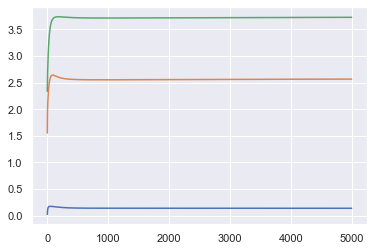

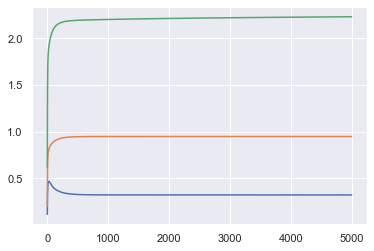

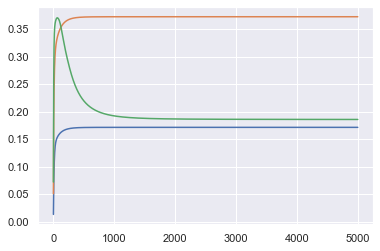

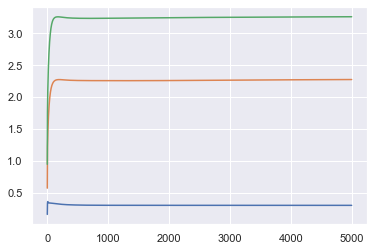

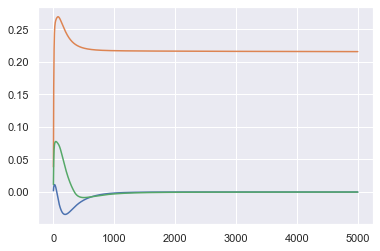

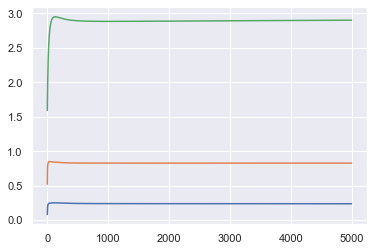

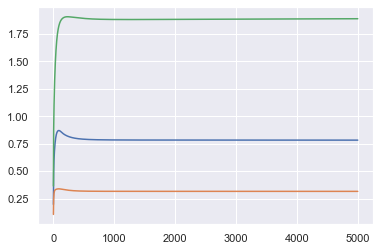

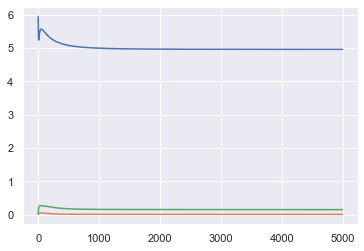

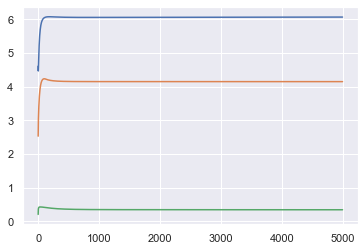

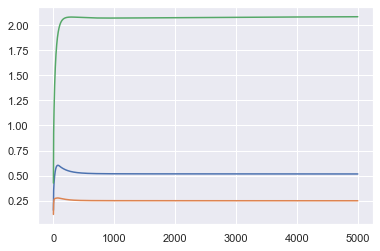

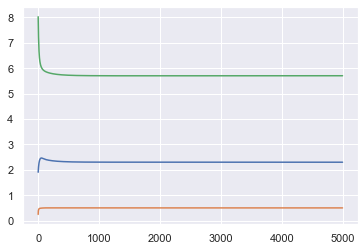

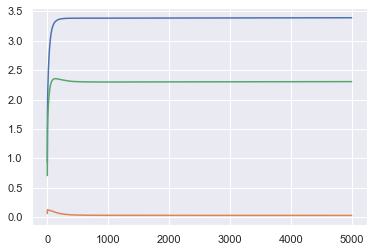

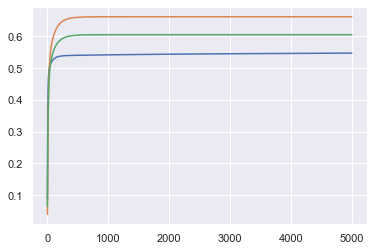

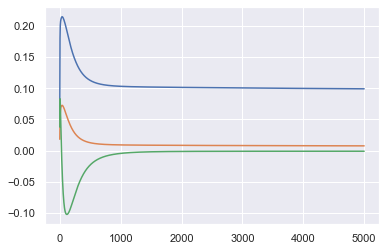

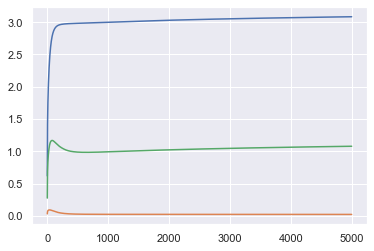

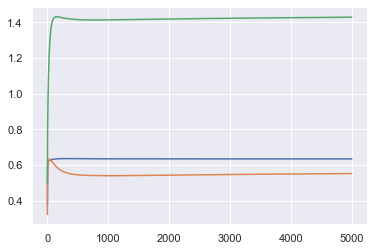

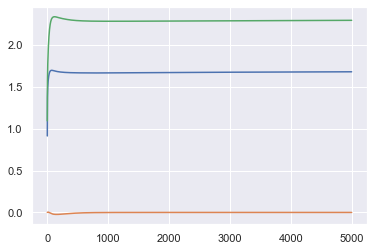

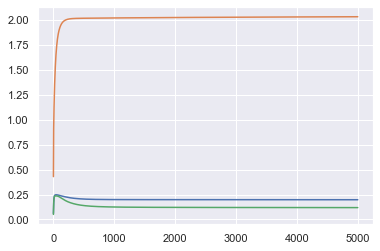

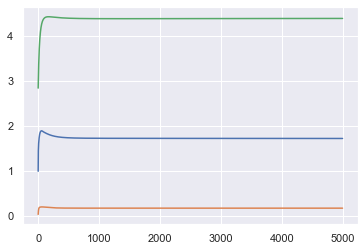

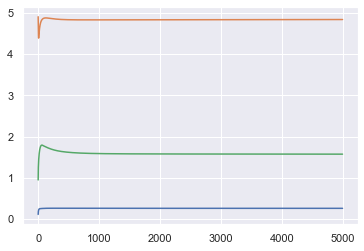

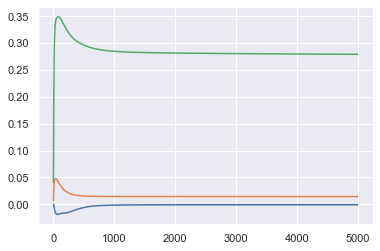

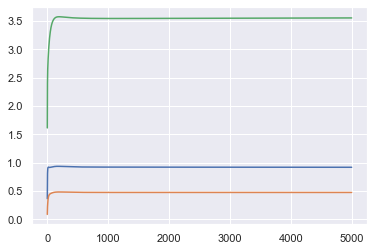

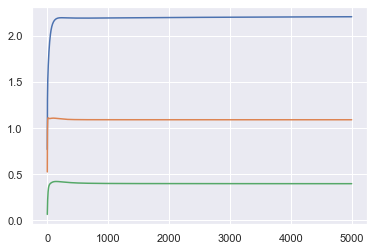

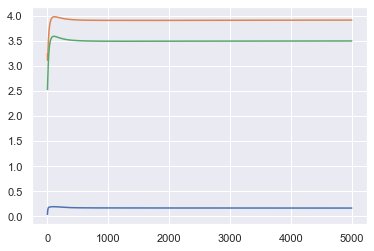

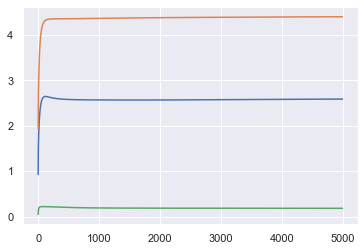

In [45]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_d[i])
    
    plt.show()

In [ ]:
for agent in agents:
    plt.plot(agent.plot_eta[0:20000])
    
    plt.show()